In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import time
import ipdb
import os
import functools
import tqdm

from math import pi

# 0. path to all results and loop annotation

In [2]:
p2results = '../../../../new_data_0422_2020/new_results_0514/bin_complex_for_left_middle_right_aggregate/'
p2results_pseudo = '../../../../new_data_0422_2020/new_results_0514/pseudo_loop_results/bin_complex_for_left_middle_right_aggregate/'
expr_name_list = os.listdir(p2results)
print(expr_name_list)
expr_name_list_pseudo = os.listdir(p2results_pseudo)
print(expr_name_list_pseudo)

['GM12878-cohesin-pooled_comp_EnrichTest_FDR_0.2_PASS_v3', 'GM12878-cohesin-pooled_comp_EnrichTest_FDR_0.2_ALL_v3', 'GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_v3', 'GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_ALL_v3']
['GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_ALL_pseudo_v3', 'GM12878-cohesin-pooled_comp_EnrichTest_FDR_0.2_PASS_pseudo_v3', 'GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_pseudo_v3', 'GM12878-cohesin-pooled_comp_EnrichTest_FDR_0.2_ALL_pseudo_v3']


In [3]:
p2filtered_loops = '../../../../new_data_0422_2020/new_loop_annotation/'
list_of_loop_annot = []
for file in os.listdir(p2filtered_loops):
    print(file)
    list_of_loop_annot.append(file)

convergent_loops_filtered_span_G150kb_middle_G20comp_nooverlap_right.txt
convergent_loops_filtered_span_G150kb_middle_G50comp_nooverlap_left.txt
convergent_loops_filtered_span_G150kb_middle_G20comp_nooverlap_left.txt
convergent_loops_filtered_span_G150kb_middle_G35comp_nooverlap_left.txt
convergent_loops_filtered_span_G150kb_middle_G50comp_nooverlap_right.txt
convergent_loops_filtered_span_G150kb_middle_G35comp_nooverlap_right.txt


------
# 1. Load data and fiter with extra loop annotation

## Only look for CTCF 0.2 PASS and cohesin 0.2 PASS

In [4]:
expr_type = ['CTCF', 'cohesin']
surfix = '0.2_PASS'

selection_filter = lambda x: ((expr_type[0] in x and surfix in x) or 
                              ((expr_type[1] in x) and (surfix in x)))

expr_name_list = [x for x in expr_name_list if selection_filter(x)]
expr_name_list_pseudo = [x for x in expr_name_list_pseudo if selection_filter(x)]

In [5]:
expr_name_list, expr_name_list_pseudo

(['GM12878-cohesin-pooled_comp_EnrichTest_FDR_0.2_PASS_v3',
  'GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_v3'],
 ['GM12878-cohesin-pooled_comp_EnrichTest_FDR_0.2_PASS_pseudo_v3',
  'GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_pseudo_v3'])

### Get pseudo and observed together.

In [6]:
###### change here to switch expr_name ######
idx = 1
#############################################

expr_name = expr_name_list[idx]
tmp_list = expr_name.split('_')
tmp_expr_name_pseudo = '_'.join(tmp_list[:-1]) + '_pseudo_' + tmp_list[-1]
if tmp_expr_name_pseudo in expr_name_list_pseudo:
    expr_name_pseudo = tmp_expr_name_pseudo
else:
    raise ValueError(f'{tmp_expr_name_pseudo} is not in the list of pseudo loop expriment (expr_name_list_pseudo)')

print(expr_name, '\n', expr_name_pseudo)

p2res_root = os.path.join(p2results, expr_name)
p2mid_left_bin = os.path.join(p2res_root, 
                              '100bin_intersected_complex_in_both_region_left_100_expansion.csv')
p2mid_right_bin = os.path.join(p2res_root,
                              '100bin_intersected_complex_in_both_region_right_100_expansion.csv')


p2res_root_pseudo = os.path.join(p2results_pseudo, expr_name_pseudo)
p2mid_left_bin_pseudo = os.path.join(p2res_root_pseudo, 
                              '100bin_intersected_complex_in_both_region_left_100_expansion.csv')
p2mid_right_bin_pseudo = os.path.join(p2res_root_pseudo,
                              '100bin_intersected_complex_in_both_region_right_100_expansion.csv')


GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_v3 
 GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_pseudo_v3


## Use G50comp as filter for observed loop

Pseudo remains the same as before

In [7]:
list_of_loop_annot.sort()

choice_of_loop_filter = 'G50comp'

list_of_loop_annot = [x for x in list_of_loop_annot if choice_of_loop_filter in x]
list_of_loop_annot

['convergent_loops_filtered_span_G150kb_middle_G50comp_nooverlap_left.txt',
 'convergent_loops_filtered_span_G150kb_middle_G50comp_nooverlap_right.txt']

In [8]:
idx_of_annot_file = 0
tmp_annot_file_name = list_of_loop_annot[idx_of_annot_file]

if 'left' in tmp_annot_file_name:
    name_left_annot = tmp_annot_file_name
    name_right_annot = name_left_annot.split('.')[0]
    name_right_annot = '_'.join(name_right_annot.split('_')[:-1]) + '_right.txt'
elif 'right' in tmp_annot_file_name:
    name_right_annot = tmp_annot_file_name
    name_left_annot = name_right_annot.split('.')[0]
    name_left_annot = '_'.join(name_left_annot.split('_')[:-1]) + '_left.txt'
#####
print(name_left_annot)
print(name_right_annot)

df_new_loop_annot_left = pd.read_csv(os.path.join(p2filtered_loops, name_left_annot), 
                                names=['loop_ID', 'num_side_gem', 'num_mid_gem'],
                               sep = '\t')

df_new_loop_annot_right = pd.read_csv(os.path.join(p2filtered_loops, name_right_annot), 
                                names=['loop_ID', 'num_side_gem', 'num_mid_gem'],
                               sep = '\t')

convergent_loops_filtered_span_G150kb_middle_G50comp_nooverlap_left.txt
convergent_loops_filtered_span_G150kb_middle_G50comp_nooverlap_right.txt


In [9]:
total_num_of_selected_loops = len(set(df_new_loop_annot_left.loop_ID.unique()).union(set(df_new_loop_annot_right.loop_ID.unique())))

In [10]:
total_num_of_selected_loops

777

### Read observed and filtered with G50comp

In [11]:
df_mid_left = pd.read_csv(p2mid_left_bin, index_col=0)
df_mid_right = pd.read_csv(p2mid_right_bin, index_col = 0)
print(df_mid_left.shape, df_mid_right.shape)

# if 'right' in list_of_loop_annot[idx_of_annot_file]:
df_mid_right = df_mid_right[df_mid_right.loop_ID.isin(df_new_loop_annot_right.loop_ID)]
# elif 'left' in list_of_loop_annot[idx_of_annot_file]:
df_mid_left = df_mid_left[df_mid_left.loop_ID.isin(df_new_loop_annot_left.loop_ID)]
    
print(df_mid_left.shape, df_mid_right.shape)

(206682, 11) (208098, 11)
(39747, 11) (38083, 11)


### Read pseudo and keep the same

In [12]:
df_mid_left_pseudo = pd.read_csv(p2mid_left_bin_pseudo, index_col=0)
df_mid_right_pseudo = pd.read_csv(p2mid_right_bin_pseudo, index_col = 0)
print(df_mid_left_pseudo.shape, df_mid_right_pseudo.shape)

(178650, 11) (181102, 11)


## Finished loading the dataset and filtering.

df_mid_left/right, df_mid_left/right_pseudo

## Flip the mid_right dataframe to the same format as mid_left

In [13]:
def index_str_to_array(idx_str):
    tmp_list = idx_str.split(';')
    idx_arr = np.array([int(x) for x in tmp_list])
    return idx_arr

def convert_to_simple_edge(idx_arr):
    np_arr = np.array([idx_arr[0], idx_arr[-1]])
    return np_arr

def from_str_to_edge(idx_str):
    return convert_to_simple_edge(index_str_to_array(idx_str))

In [14]:
def flip_mid_right_to_mid_left(df_mid_right):
    '''
    change the columns '100_bin_index_vectors' and 'position' in df_mid_right
    to the same range and format as df_mid_left.
    '''
    tmp_index_array_column = df_mid_right['100_bin_index_vectors'].apply(index_str_to_array)
    tmp_index_array_column_flip = 100 - tmp_index_array_column
    tmp_index_array_column_flip = tmp_index_array_column_flip.apply(np.sort)
    
    convert_bin_index_array_to_str = lambda x : ';'.join([str(i) for i in x])
    new_100_bin_index_vectors = tmp_index_array_column_flip.apply(convert_bin_index_array_to_str)
    
    flipped_df = df_mid_right.copy()
    flipped_df['100_bin_index_vectors'] = new_100_bin_index_vectors
    
    convert_position_to_right = lambda x: x.replace('Right', 'Left')
    flipped_df['position'] = flipped_df['position'].apply(convert_position_to_right)
    return flipped_df

In [15]:
df_mid_right_flipped = flip_mid_right_to_mid_left(df_mid_right)
df_mid_right_pseudo_flipped = flip_mid_right_to_mid_left(df_mid_right_pseudo)

df_mid_left_combine_with_mid_right_flipped = pd.concat((df_mid_left, df_mid_right_flipped))
df_mid_left_pseudo_combine_with_mid_right_pseudo_flipped = pd.concat((df_mid_left_pseudo, df_mid_right_pseudo_flipped))


In [16]:
print(df_mid_left_combine_with_mid_right_flipped.shape, df_mid_left_pseudo_combine_with_mid_right_pseudo_flipped.shape)

(77830, 11) (359752, 11)


In [17]:
print(df_mid_left.shape, df_mid_right.shape)
print(df_mid_left_pseudo.shape, df_mid_right_pseudo.shape)

(39747, 11) (38083, 11)
(178650, 11) (181102, 11)


------
# 2. Get the gem counts for left/right for both observed and pseudo

In [18]:
mid_position_template = 'mid_region_overlap_{}_motif'
side_position_template = '{}_expand_region'


# get gem count for mid_left, mid_right, mid_left_pseudo, mid_right_pseudo.

tmp_list = ['mid_left', 'mid_right', 'mid_left_pseudo', 'mid_right_pseudo', 
            'mid_left_right_combined', 
            'mid_left_right_pseudo_combined']
df_list = [df_mid_left, df_mid_right, df_mid_left_pseudo, df_mid_right_pseudo,
          df_mid_left_combine_with_mid_right_flipped,
          df_mid_left_pseudo_combine_with_mid_right_pseudo_flipped]

id2pos_name = {x:y for x, y in enumerate(tmp_list)}
pos_name2id = {y:x for x, y in id2pos_name.items()}

pos_name2df = {x:y for x, y in zip(tmp_list, df_list)}
pos_name2gem_count = {}

union_of_loops_in_new_annotation = set(df_new_loop_annot_left.loop_ID.unique()).union(set(df_new_loop_annot_right.loop_ID.unique()))

# num_of_total_observed_loops = 13549
num_of_total_observed_loops = len(union_of_loops_in_new_annotation)
num_of_total_pseudo_loops = 30000

for idx in range(len(tmp_list)):
    cur_name = id2pos_name[idx]
    cur_df = pos_name2df[cur_name]
    
    cur_position = cur_name.split('_')[1].capitalize()
    
    mid_position = mid_position_template.format(cur_position)
    side_position = side_position_template.format(cur_position)

    df_mid_side_mid_only = cur_df[cur_df['position'] == 
                                      mid_position]
    df_mid_side_side_only = cur_df[cur_df['position'] ==
                                       side_position]
    mid_gem_num = df_mid_side_mid_only.shape[0]
    side_gem_num = df_mid_side_side_only.shape[0]
    
    mid_frag_num = df_mid_side_mid_only['num_intersected_frag'].sum()
    side_frag_num = df_mid_side_side_only['num_intersected_frag'].sum()
    
    if cur_position == 'Right':
        _mid_right_gem_num = [mid_gem_num, side_gem_num]
        _mid_right_frag_num = [mid_frag_num, side_frag_num]
        pos_name2gem_count[cur_name] = {
            'mid_gem_count': mid_gem_num,
            'right_gem_count': side_gem_num,
            'mid_frag_count': mid_frag_num,
            'right_frag_count': side_frag_num
        }
        
        if 'pseudo' in cur_name:
            mid_right_gem_count = np.array(_mid_right_gem_num)
            mid_right_frag_count = np.array(_mid_right_frag_num)
            mid_right_gem_count = mid_right_gem_count / num_of_total_pseudo_loops * num_of_total_observed_loops
            mid_right_frag_count = mid_right_frag_count / num_of_total_pseudo_loops * num_of_total_observed_loops
            
            mid_right_gem_count = np.ceil(mid_right_gem_count).astype(int)
            mid_right_frag_count = np.ceil(mid_right_frag_count).astype(int)
            
            pos_name2gem_count[cur_name]['normalized_mid_gem_count'] = mid_right_gem_count[0]
            pos_name2gem_count[cur_name]['normalized_right_gem_count'] = mid_right_gem_count[1]
            
            pos_name2gem_count[cur_name]['normalized_mid_frag_count'] = mid_right_frag_count[0]
            pos_name2gem_count[cur_name]['normalized_right_frag_count'] = mid_right_frag_count[1]
    else:
        _left_mid_gem_num = [side_gem_num, mid_gem_num]
        _left_mid_frag_num = [side_frag_num, mid_frag_num]
        pos_name2gem_count[cur_name] = {
            'mid_gem_count': mid_gem_num,
            'left_gem_count': side_gem_num,
            'mid_frag_count': mid_frag_num,
            'left_frag_count': side_frag_num
        }

        if 'pseudo' in cur_name:
            left_mid_gem_count = np.array(_left_mid_gem_num)
            left_mid_frag_count = np.array(_left_mid_frag_num)
            left_mid_gem_count = left_mid_gem_count / num_of_total_pseudo_loops * num_of_total_observed_loops
            left_mid_frag_count = left_mid_frag_count / num_of_total_pseudo_loops * num_of_total_observed_loops
            
            left_mid_gem_count = np.ceil(left_mid_gem_count).astype(int)
            left_mid_frag_count = np.ceil(left_mid_frag_count).astype(int)
            
            pos_name2gem_count[cur_name]['normalized_mid_gem_count'] = left_mid_gem_count[1]
            pos_name2gem_count[cur_name]['normalized_left_gem_count'] = left_mid_gem_count[0]
            
            pos_name2gem_count[cur_name]['normalized_mid_frag_count'] = left_mid_frag_count[0]
            pos_name2gem_count[cur_name]['normalized_left_frag_count'] = left_mid_frag_count[1]



In [19]:
from pprint import pprint
pprint(pos_name2gem_count)

pprint([pos_name2gem_count['mid_left_right_combined'][x] for x in ['left_gem_count', 'mid_gem_count']])
pprint([pos_name2gem_count['mid_left_right_combined'][x] for x in ['left_frag_count', 'mid_frag_count']])

pprint([pos_name2gem_count['mid_left_right_pseudo_combined'][x] for x in ['left_gem_count', 'mid_gem_count']])
pprint([pos_name2gem_count['mid_left_right_pseudo_combined'][x] for x in ['left_frag_count', 'mid_frag_count']])

pprint([pos_name2gem_count['mid_left_right_pseudo_combined'][x] for x in ['normalized_left_gem_count', 
                                                                          'normalized_mid_gem_count']])
pprint([pos_name2gem_count['mid_left_right_pseudo_combined'][x] for x in ['normalized_left_frag_count', 
                                                                          'normalized_mid_frag_count']])

{'mid_left': {'left_frag_count': 22762,
              'left_gem_count': 10709,
              'mid_frag_count': 63285,
              'mid_gem_count': 29038},
 'mid_left_pseudo': {'left_frag_count': 199258,
                     'left_gem_count': 89985,
                     'mid_frag_count': 195964,
                     'mid_gem_count': 88665,
                     'normalized_left_frag_count': 5076,
                     'normalized_left_gem_count': 2331,
                     'normalized_mid_frag_count': 5161,
                     'normalized_mid_gem_count': 2297},
 'mid_left_right_combined': {'left_frag_count': 45188,
                             'left_gem_count': 21224,
                             'mid_frag_count': 123251,
                             'mid_gem_count': 56606},
 'mid_left_right_pseudo_combined': {'left_frag_count': 400971,
                                    'left_gem_count': 180980,
                                    'mid_frag_count': 395201,
                           

# 3. Functions for drawing arcs

## This part has nothing to do gem counts, just ploting functions

In [20]:
def draw_circle(ax, a, b, angle = 180, side = False, idx = 0, **kwarg):
    assert angle <= 180
    left = min(a, b)
    right = max(a, b)
    center_x = (left + right) / 2
    e1 = (right - left) / 2
    alpha = 2 * pi * angle / 360
    e2 = e1 / np.tan(alpha/2)
    center_y = -e2
    radius = np.sqrt(e1 ** 2 + e2 ** 2)
    
    x = np.linspace(a, b, 100)
    y = center_y + np.sqrt(radius ** 2 - (x - center_x)**2)
    y = y * idx / 2
    
    max_y = max(y)
    if side == True:
        y *= -1
    ax.plot(x, y, **kwarg)
    return radius, max_y

def draw_ellipse(ax, a, b, angle = None, side = False, idx = 0, **kwarg):
    left = min(a, b)
    right = max(a, b)
    
    center_x = (left + right) / 2
    center_y = 0
    
    x_radius = (right - left) / 2
    y_radius = x_radius / 20 + 5e-1 * idx
    
    t = np.linspace(0, pi, 100)
    x = center_x + x_radius * np.cos(t)
    y = center_y + y_radius * np.sin(t)
    
    max_y = max(y)
    
    if side == True:
        y *= -1
        max_y *= -1
    ax.plot(x, y, **kwarg)
    return x_radius, max_y

In [21]:
def arc_plot_for_list(tmp_list, ax, angle = 180, arctype = 'ellipse',
                      side = False, y_min = None, y_max = None, 
                      x_min = None, x_max = None,
                     **kwarg):
    
    if arctype == 'circle':
        draw_arc = draw_circle
    elif arctype == 'ellipse':
        draw_arc = draw_ellipse
    
    larges_raduis = max_y = 0
    left_most = float("inf")
    right_most = float("-inf")
    
    for idx, pair in enumerate(tmp_list):
        if pair[1] == pair[0]:
            continue
        
        tmp_radius, tmp_max_y = draw_arc(ax, pair[0], pair[1],
                                  angle = angle, 
                              side = side, idx = idx,
                              **kwarg)
        larges_raduis = max(larges_raduis, tmp_radius)
        
        max_y = np.max(np.abs([tmp_max_y, max_y]))
        left_most = min(pair[0], left_most)
        right_most = max(pair[1], right_most)

    x_buffer = np.clip(larges_raduis * 0.05, 0.01, 1)

    left = left_most
    right = right_most
    
#     ipdb.set_trace()
    if x_min is None or x_max is None:
        x_min, x_max = left - x_buffer, right + x_buffer
    if y_min is None or y_max is None:
        y_min, y_max = -x_buffer, max_y + x_buffer
        if side:
            y_min, y_max = -y_max, -y_min
    
    return x_min, x_max, y_min, y_max

## Draw two sides of the arc, adjusted Y-axis to gem count numbers

In [22]:
def two_position_side_by_side(mid_complex_list, side_complex_list,
                              left_mid_gem_count,
                              mid_right_gem_count, 
                              max_count,
                              ax0,
                              same_direction = False,
                              arctype = 'circle',
                              side_position = 'Left', 
                              y_min = None, y_max = None, 
                              x_min = None, x_max = None,                               
                              **kwarg):
    '''
    when sid_position is 'left' put mid list on right and side list on left.
    vice versa
    '''
#     fig, ax0 = plt.subplots(1, 1, sharex = True, sharey = True)

    x_min_mid, x_max_mid, y_min_mid, y_max_mid = arc_plot_for_list(mid_complex_list, ax0,
                                                          arctype=arctype,
                                                          x_min = x_min,
                                                          x_max = x_max,
                                                          y_min = y_min,
                                                          y_max = y_min,
                                                          **kwarg)
    x_min_side, x_max_side, y_min_side, y_max_side = arc_plot_for_list(side_complex_list, ax0, 
                                                              side = True, arctype=arctype,
                                                             x_min = x_min,
                                                          x_max = x_max,
                                                          y_min = y_min,
                                                          y_max = y_min,
                                                             **kwarg)
    
    
    if side_position == 'Left':
        x_min, x_max = -105, 105
    elif side_position == 'Right':
        if same_direction:
            x_min, x_max = -105, 105
        else:
            x_min, x_max = -5, 205
    else:      
        x_max = max(np.abs([x_max_mid, x_max_side, x_min_mid, x_min_side]))
        x_min = -x_max
    
    max_count = max_count
    
    ax0.set_aspect('auto')
    ax0.set_xlim(x_min, x_max)
    y_max = max(np.abs([y_max_mid, y_min_side]))
    
    
    
    if side_position == 'Left':
        y_ticks_loc = np.array([0, y_min_side, y_max_mid,  0])     
        if max(left_mid_gem_count) < max_count:
            y_max = y_max / max(left_mid_gem_count) * max_count
        y_ticks_loc[0] = -y_max
        y_ticks_loc[-1] = y_max
        ax0.set_yticks(y_ticks_loc) 
        ax0.set_yticklabels([-max_count, 
                             -min(left_mid_gem_count), 
                             max(left_mid_gem_count), 
                             max_count], fontsize = 6)
    else:
        y_ticks_loc = np.array([0, y_min_side, y_max_mid,  0])     
        if max_count > max(mid_right_gem_count):
            y_max = y_max / max(mid_right_gem_count) * max_count
        y_ticks_loc[0] = -y_max
        y_ticks_loc[-1] = y_max
        ax0.set_yticks(y_ticks_loc) 
        ax0.set_yticklabels([-max_count, 
                             -min(mid_right_gem_count), 
                             max(mid_right_gem_count), 
                             max_count], fontsize = 6)
        
    ax0.set_ylim(-y_max * 1.05, y_max * 1.05)


    
    

## Wrapper for drawing two sides of the arc

In [23]:
def plot_mid_and_side(ax0, df_mid_side, 
                      left_mid_gem_count,
                      mid_right_gem_count, 
                      max_count,
                      position,
                      same_direction = False,
                      sample = 1, **kwarg):
    
    mid_side_mid_idx = df_mid_side['position'] == 'mid_region_overlap_{}_motif'.format(position)
    mid_side_side_idx = ~mid_side_mid_idx

    df_mid_side_mid_only = df_mid_side[mid_side_mid_idx].sort_values(by = ['gem_intersected_span'])
    df_mid_side_side_only = df_mid_side[mid_side_side_idx].sort_values(by = ['gem_intersected_span'])

    mid_side_mid_arr = df_mid_side_mid_only['100_bin_index_vectors'].apply(from_str_to_edge)
    mid_side_side_arr = df_mid_side_side_only['100_bin_index_vectors'].apply(from_str_to_edge)
    
    if same_direction and (position == 'Right'):
        flip_right_gems = lambda x: 100 - x
        mid_side_mid_arr = mid_side_mid_arr.apply(flip_right_gems)
        mid_side_side_arr = mid_side_side_arr.apply(flip_right_gems)
            
    if 'alpha' in kwarg:
        alpha = kwarg['alpha']
    else:
        alpha = 0.01
    
    two_position_side_by_side(mid_side_mid_arr[::sample], mid_side_side_arr[::sample],
                              left_mid_gem_count,
                              mid_right_gem_count,
                              max_count,
                              ax0, 
                              same_direction = same_direction,
                              arctype = 'ellipse',
                              side_position = position, y_min = None, 
                              y_max = None, x_min = None, 
                              x_max = None, 
                              
                              alpha = alpha, **kwarg)

# 4. Functions for drawing sorted GEMs

In [24]:
def plot_order_gems(ax1, df_mid_side, 
                    max_gem_count, 
                    sample_gap = 100,
                    pseudo = False,
                    num_of_total_pseudo_loops = 30000,
                    num_of_total_observed_loops = 777, 
                    same_direction = False,
                    position = 'Left', **kwarg):
    mid_side_mid_idx = df_mid_side['position'] == 'mid_region_overlap_{}_motif'.format(position)
    mid_side_side_idx = ~mid_side_mid_idx

    df_mid_side_mid_only = df_mid_side[mid_side_mid_idx].sort_values(by = ['gem_intersected_span'])
    df_mid_side_side_only = df_mid_side[mid_side_side_idx].sort_values(by = ['gem_intersected_span'])

    mid_side_mid_arr = df_mid_side_mid_only['100_bin_index_vectors'].apply(from_str_to_edge)
    mid_side_side_arr = df_mid_side_side_only['100_bin_index_vectors'].apply(from_str_to_edge)
    
    mid_side_mid_arr = mid_side_mid_arr[::sample_gap]
    mid_side_side_arr = mid_side_side_arr[::sample_gap]
    
    mid_center_points = df_mid_side_mid_only['100_bin_index_vectors'].apply(
        lambda x: index_str_to_array(x)[1:-1])
    side_center_points = df_mid_side_side_only['100_bin_index_vectors'].apply(
        lambda x: index_str_to_array(x)[1:-1])
    
    mid_center_points = mid_center_points[::sample_gap]
    side_center_points = side_center_points[::sample_gap]

    
    mid_len = len(mid_side_mid_arr)
    side_len = len(mid_side_side_arr)
    
    mid_center_y = [idx * sample_gap * np.ones_like(x) for idx, x in enumerate(mid_center_points.values[::-1])]
    mid_center_points_y = np.concatenate(mid_center_y)
    mid_center_points_x = np.concatenate(mid_center_points.values[::-1])
    
    side_center_y = [idx * sample_gap * np.ones_like(x) for idx, x in enumerate(side_center_points.values[::-1])]
    side_cneter_points_y = np.concatenate(side_center_y)
    side_center_points_x = np.concatenate(side_center_points.values[::-1])
        
    if position == 'Right' and same_direction == True:
        flip_right_side = lambda x: 100 - x
        side_center_points_x = flip_right_side(side_center_points_x)
        mid_center_points_x = flip_right_side(mid_center_points_x) 
        
        mid_side_mid_arr = mid_side_mid_arr.apply(flip_right_side)
        mid_side_side_arr = mid_side_side_arr.apply(flip_right_side)
        
    s = 0.01
    ax1.scatter(mid_center_points_x, mid_center_points_y, 
                color = color, s = s, alpha = 0.5)
    ax1.scatter(side_center_points_x, side_cneter_points_y, 
                color = color, s = s, alpha = 0.5)
    
    y_len = max(mid_len, side_len)
    
    if position == 'Left':
        mid_idx = 1
        side_idx = 0
    elif position == 'Right':
        mid_idx = 0
        side_idx = 1

            
    x_mid = [x[mid_idx] for x in mid_side_mid_arr]
    y_mid = [sample_gap * x for x in range(0, len(x_mid))[::-1]]
    
    x_side = [x[side_idx] for x in mid_side_side_arr]
    y_side = [sample_gap * x for x in range(0, len(x_side))[::-1]]
    
    ax1.plot(x_mid, y_mid, **kwarg)
    ax1.plot(x_side, y_side, **kwarg)
    max_gem_count = max_gem_count
    
    roundup = lambda x: x if x % 1000 == 0 else x + 1000 - x % 1000
    
    step_size = roundup(max_gem_count // 10)
    y_ticks_original = np.arange(0, int(np.ceil(max_gem_count/step_size)* step_size) + 1, 
                                 step_size)
    if pseudo == 1:
        max_gem_count = max_gem_count / num_of_total_observed_loops * num_of_total_pseudo_loops
        step_size = roundup(max_gem_count // 10)
        y_ticks = np.arange(0, int(np.ceil(max_gem_count/step_size)* step_size) + 1, 
                            step_size)
        ax1.set_yticks(y_ticks)
    else:
        ax1.set_yticks(y_ticks_original)
        
    ax1.set_ylim(-100, max_gem_count * 1.05)   
    ax1.set_yticklabels(y_ticks_original, fontsize = 6)
    

## Plot ordered gems in vertical order


In [25]:
def plot_order_gems_vertical(ax0, ax1, df_mid_side, 
                    max_gem_count, 
                    sample_gap = 100,
                    pseudo = False,
                    num_of_total_pseudo_loops = 30000,
                    num_of_total_observed_loops = 777, 
                    same_direction = False,
                    position = 'Left', **kwarg):
    mid_side_mid_idx = df_mid_side['position'] == 'mid_region_overlap_{}_motif'.format(position)
    mid_side_side_idx = ~mid_side_mid_idx

    df_mid_side_mid_only = df_mid_side[mid_side_mid_idx].sort_values(by = ['gem_intersected_span'])
    df_mid_side_side_only = df_mid_side[mid_side_side_idx].sort_values(by = ['gem_intersected_span'])

    mid_side_mid_arr = df_mid_side_mid_only['100_bin_index_vectors'].apply(from_str_to_edge)
    mid_side_side_arr = df_mid_side_side_only['100_bin_index_vectors'].apply(from_str_to_edge)
    
    mid_side_mid_arr = mid_side_mid_arr[::sample_gap]
    mid_side_side_arr = mid_side_side_arr[::sample_gap]
    
    mid_center_points = df_mid_side_mid_only['100_bin_index_vectors'].apply(
        lambda x: index_str_to_array(x)[1:-1])
    side_center_points = df_mid_side_side_only['100_bin_index_vectors'].apply(
        lambda x: index_str_to_array(x)[1:-1])
    
    mid_center_points = mid_center_points[::sample_gap]
    side_center_points = side_center_points[::sample_gap]

    
    mid_len = len(mid_side_mid_arr)
    side_len = len(mid_side_side_arr)
    
    mid_center_y = [idx * sample_gap * np.ones_like(x) for idx, x in enumerate(mid_center_points.values[::-1])]
    mid_center_points_y = np.concatenate(mid_center_y)
    mid_center_points_x = np.concatenate(mid_center_points.values[::-1])
    
    side_center_y = [idx * sample_gap * np.ones_like(x) for idx, x in enumerate(side_center_points.values[::-1])]
    side_cneter_points_y = np.concatenate(side_center_y)
    side_center_points_x = np.concatenate(side_center_points.values[::-1])
        
    if position == 'Right' and same_direction == True:
        flip_right_side = lambda x: 100 - x
        side_center_points_x = flip_right_side(side_center_points_x)
        mid_center_points_x = flip_right_side(mid_center_points_x) 
        
        mid_side_mid_arr = mid_side_mid_arr.apply(flip_right_side)
        mid_side_side_arr = mid_side_side_arr.apply(flip_right_side)
        
    s = 0.01
    ax0.scatter(mid_center_points_x, mid_center_points_y, 
                color = color, s = s, alpha = 0.5)
    ax1.scatter(side_center_points_x, side_cneter_points_y, 
                color = color, s = s, alpha = 0.5)
    
    y_len = max(mid_len, side_len)
    
    if position == 'Left':
        mid_idx = 1
        side_idx = 0
    elif position == 'Right':
        mid_idx = 0
        side_idx = 1

            
    x_mid = [x[mid_idx] for x in mid_side_mid_arr]
    y_mid = [sample_gap * x for x in range(0, len(x_mid))[::-1]]
    
    x_side = [x[side_idx] for x in mid_side_side_arr]
    y_side = [sample_gap * x for x in range(0, len(x_side))[::-1]]
    
    ax0.plot(x_mid, y_mid, **kwarg)
    ax1.plot(x_side, y_side, **kwarg)
    max_gem_count = max_gem_count
    
    roundup = lambda x: x if x % 1000 == 0 else x + 1000 - x % 1000
    
    step_size = roundup(max_gem_count // 10)
    y_ticks_original = np.arange(0, int(np.ceil(max_gem_count/step_size)* step_size) + 1, 
                                 step_size)
    
    if pseudo == 1:
        max_gem_count = max_gem_count / num_of_total_observed_loops * num_of_total_pseudo_loops
        step_size = roundup(max_gem_count // 10)
        y_ticks = np.arange(0, int(np.ceil(max_gem_count/step_size)* step_size) + 1, 
                            step_size)
        ax0.set_yticks(y_ticks)
        ax1.set_yticks(y_ticks)
    else:
        ax0.set_yticks(y_ticks_original)
        ax1.set_yticks(y_ticks_original)
        
    for ax in [ax0, ax1]:
        ax.set_ylim(-100, max_gem_count * 1.05)   
        ax.set_yticklabels(y_ticks_original, fontsize = 6)
    

# Test arc plot for all for cases

For observed, plot left-mid and mid-right together. For pseudo, plot the same.

In [26]:
id2pos_name

{0: 'mid_left',
 1: 'mid_right',
 2: 'mid_left_pseudo',
 3: 'mid_right_pseudo',
 4: 'mid_left_right_combined',
 5: 'mid_left_right_pseudo_combined'}

GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_v3
777 30000
mid_left_right_combined
56606 [10709, 29038] [27568, 10515]
mid_left_right_pseudo_combined
56606 [2331, 2297] [2334, 2357]


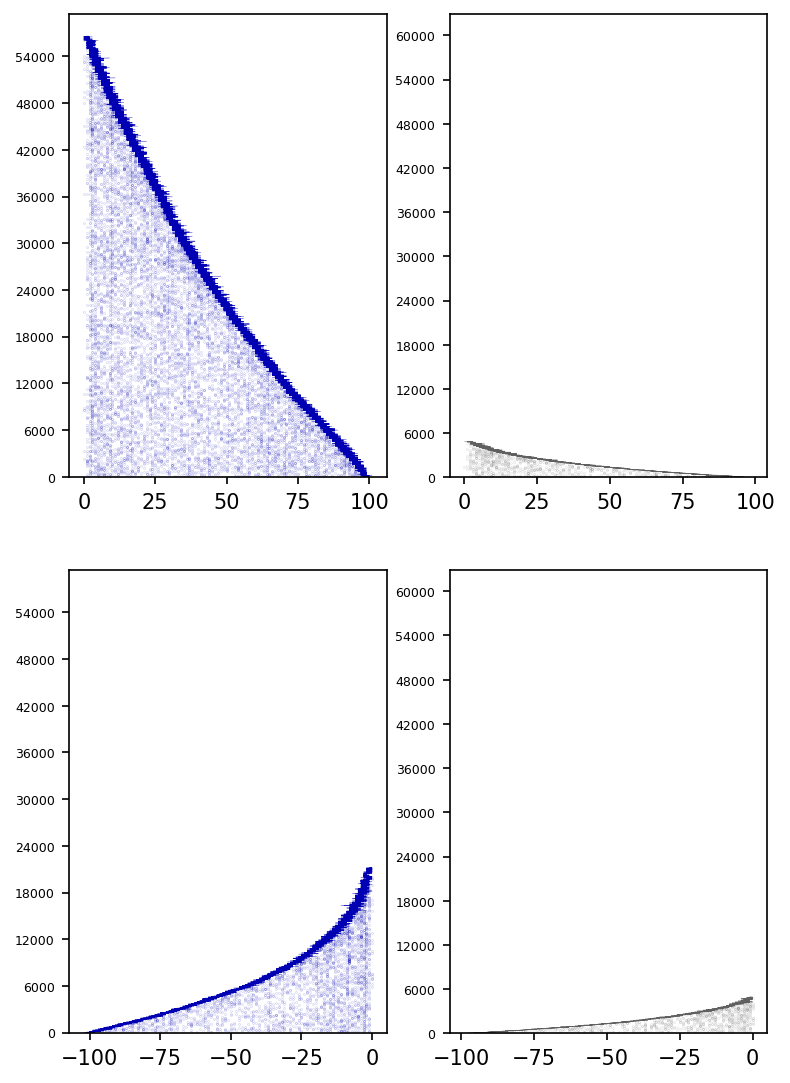

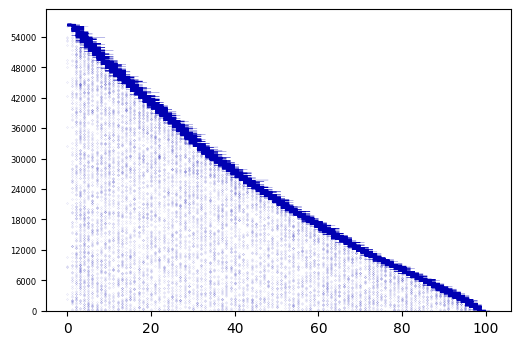

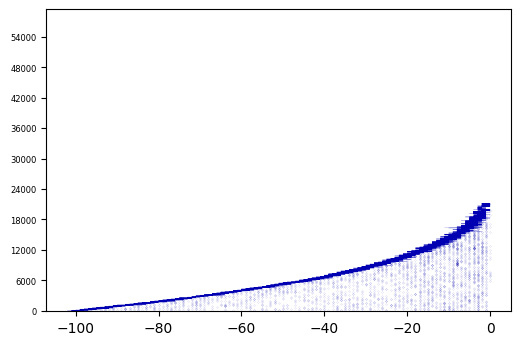

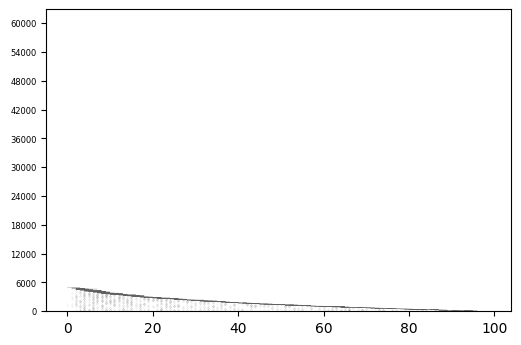

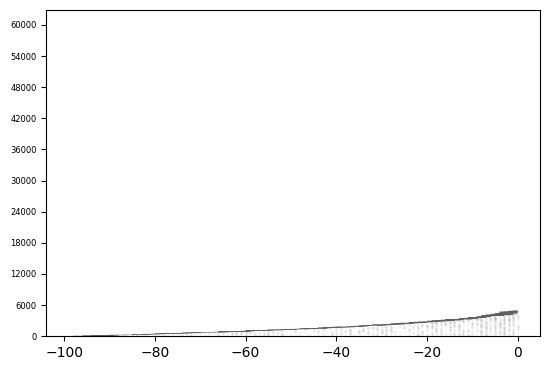

In [28]:
print(expr_name)
print(num_of_total_observed_loops, num_of_total_pseudo_loops)

#### ALL parameters ####

choose_normalized_pseudo_gem_count = True
same_direction = True
observed_loop_sample_gap = 100
pseudo_loop_sample_gap = 500

observed_loop_sample_gap_ordered_gem_plot = 1
pseudo_loop_sample_gap_ordered_gem_plot = 50

########################


# idx_list = [pos_name2id[x] for x in pos_name2id.keys() if 'pseudo' in x]
idx_list = [pos_name2id[x] for x in pos_name2id.keys() if 'combined' in x]
# idx_list = range(4)
fig, ax = plt.subplots(2, len(idx_list), 
                       gridspec_kw={'height_ratios': [1, 1]},
#                        sharex = True,
#                        sharey = True,
                       figsize = (3 * len(idx_list), 9),
                      dpi = 150)


for ax_idx, idx in enumerate(idx_list):
    cur_pos_name = id2pos_name[idx]
    pseudo = ('pseudo' in cur_pos_name)

    cur_position = cur_pos_name.split('_')[1].capitalize()
    cur_df = pos_name2df[cur_pos_name]
    print(cur_pos_name)
    
    template_gem_count_list_left = ['mid_gem_count', 'left_gem_count']
    template_gem_count_list_right = ['mid_gem_count', 'right_gem_count']
    max_gem_count = max(max(pos_name2gem_count['mid_left'][x] for x in template_gem_count_list_left), 
                        max(pos_name2gem_count['mid_right'][x] for x in template_gem_count_list_right), 
                        max(pos_name2gem_count['mid_left_right_combined'][x] for x in template_gem_count_list_left))
    
    if choose_normalized_pseudo_gem_count:
        pseudo_left_mid_gem_count_list = [pos_name2gem_count['mid_left_pseudo'][x] for x in ['normalized_left_gem_count', 
                                                                                             'normalized_mid_gem_count']]
        pseudo_right_mid_gem_count_list = [pos_name2gem_count['mid_right_pseudo'][x] for x in ['normalized_right_gem_count', 
                                                                                               'normalized_mid_gem_count']]

    else:
        pseudo_left_mid_gem_count_list = [pos_name2gem_count['mid_left_pseudo'][x] for x in ['left_gem_count',
                                                                                            'mid_gem_count']]
        pseudo_right_mid_gem_count_list = [pos_name2gem_count['mid_right_pseudo'][x] for x in ['right_gem_count',
                                                                                              'mid_gem_count']]
    
    max_gem_count = max(max_gem_count, 
                       max(pseudo_left_mid_gem_count_list),
                       max(pseudo_right_mid_gem_count_list))
                                           
    if pseudo == 0:
        left_mid_gem_count = [pos_name2gem_count['mid_left']['left_gem_count'],
                              pos_name2gem_count['mid_left']['mid_gem_count']]
        mid_right_gem_count = [pos_name2gem_count['mid_right']['mid_gem_count'],
                              pos_name2gem_count['mid_right']['right_gem_count']]
        arc_plot_sample = observed_loop_sample_gap
        ordered_gem_plot_sample = observed_loop_sample_gap_ordered_gem_plot
        
    elif pseudo == 1:
        left_mid_gem_count = pseudo_left_mid_gem_count_list
        mid_right_gem_count = pseudo_right_mid_gem_count_list[::-1]
        
        arc_plot_sample = pseudo_loop_sample_gap
        ordered_gem_plot_sample = pseudo_loop_sample_gap_ordered_gem_plot
        

    print(max_gem_count, left_mid_gem_count, mid_right_gem_count)
    
    cur_ax0 = ax[0][ax_idx]
    
    cur_ax1 = ax[1][ax_idx]
    if pseudo:
        color = '#606060'
    elif 'CTCF' in expr_name:
        color = '#0000B2'
    elif 'cohesin' in expr_name:
        color = '#005900'
    
    plot_order_gems_vertical(cur_ax0,
                             cur_ax1,
                             cur_df, 
                    max_gem_count, 
                    sample_gap = ordered_gem_plot_sample,
                    pseudo = pseudo,
                    num_of_total_pseudo_loops = num_of_total_pseudo_loops,
                    num_of_total_observed_loops = num_of_total_observed_loops, 
                    same_direction = same_direction,
                    position = cur_position, 
                   color = color, lw = 0.1)
    
    tmp_fig0, tmp_ax0 = plt.subplots(1)
    tmp_fig1, tmp_ax1 = plt.subplots(1)
    plot_order_gems_vertical(tmp_ax0,
                             tmp_ax1,
                             cur_df, 
                    max_gem_count, 
                    sample_gap = ordered_gem_plot_sample,
                    pseudo = pseudo,
                    num_of_total_pseudo_loops = num_of_total_pseudo_loops,
                    num_of_total_observed_loops = num_of_total_observed_loops, 
                    same_direction = same_direction,
                    position = cur_position, 
                   color = color, lw = 0.1)
    tmp_fig0.savefig(f'{expr_name}_{cur_pos_name}_ordered_gem_middle_region.png',
                    dpi = 250)
    tmp_fig1.savefig(f'{expr_name}_{cur_pos_name}_ordered_gem_left_and_right_region.png',
                    dpi = 250)
    
plt.tight_layout()   
plt.show()
plt.close()


# 5. Functions for heatmap plots

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.sparse import lil_matrix


mpl.rcParams['figure.dpi'] = 100

import time
import ipdb
import os
import functools
import tqdm

from math import pi

In [29]:
print(df_mid_left.shape, df_mid_right.shape)
print(df_mid_left_pseudo.shape, df_mid_right_pseudo.shape)

(39747, 11) (38083, 11)
(178650, 11) (181102, 11)


In [30]:
def expand_to_common_gem_loop_id(df_mid_side, position = 'Left'):
    '''
    goal: combine gems in middle and side region with same GEM_ID to one gem.
    '''
    mid_side_mid_idx = df_mid_side['position'] == 'mid_region_overlap_{}_motif'.format(position)
    mid_side_side_idx = ~mid_side_mid_idx

    df_mid_side_mid_only = df_mid_side[mid_side_mid_idx].sort_values(by = ['gem_intersected_span'])
    df_mid_side_side_only_all = df_mid_side[mid_side_side_idx]
    
    # each row has a loop ID and GEM ID. Combine them together to have a unique
    # 'id' for each row. If they are the same, then two rows are connected at the motif
    # region. (same loop, same gem)
    combine_gem_loop = lambda x: ';'.join([x.GEM_ID, x.loop_ID])
    mid_gem_loop_id = df_mid_side_mid_only.apply(combine_gem_loop, axis = 1)
    side_gem_loop_id = df_mid_side_side_only_all.apply(combine_gem_loop, axis = 1)
    all_gem_loop_id = df_mid_side.apply(combine_gem_loop, axis = 1)
    
    # find the share combined ID in df_side and df_mid. i.e. Rows that should be connected.
    side2mid_common_id_idx = side_gem_loop_id.isin(mid_gem_loop_id)
    mid2side_common_id_idx = mid_gem_loop_id.isin(side_gem_loop_id)
    
#     ipdb.set_trace()
    # common, GEM_LOOP id. 
    comm_gem_loop_id = side_gem_loop_id[side2mid_common_id_idx]
    
    for loop_gem_id in comm_gem_loop_id:
        # When searching in df_mid_side, GEM_LOOP id might not be unique.
        # Because same row may be shared in both middle and side region.
        
        # ONLY in df_mide_side_mid_only, or df_mid_side_side_only, this ID is unique.
        # We are only searching the common GEM_LOOP id. 
        # Hence, df_tmp has and only has 2 rows.
        df_tmp = df_mid_side[all_gem_loop_id == loop_gem_id]
        
        # Get two values from 
        bin_index_vectors_list = df_tmp['100_bin_index_vectors'].values
        if bin_index_vectors_list[0] != bin_index_vectors_list[1]:
            combine_vectors = ';'.join(bin_index_vectors_list)
#         ipdb.set_trace()
            df_mid_side.loc[all_gem_loop_id == loop_gem_id, '100_bin_index_vectors'] = [combine_vectors, 
                                                                                     combine_vectors]
            # remove the second row (duplicated)
            df_mid_side.drop(df_tmp.index[0])
    
    df_mid_side = df_mid_side.drop_duplicates(['GEM_ID', 'loop_ID'])
    return df_mid_side

------
## 5.1 Combined gems in mid_left, mid_right, mid_left/right_pseudo in parallel

In [31]:
df_list = [df_mid_left, df_mid_right, df_mid_left_pseudo, df_mid_right_pseudo]
# df_list = [df_mid_left_pseudo, df_mid_right_pseudo]
df_list = [x.copy() for x in df_list]

position_list = ['Left', 'Right', 'Left', 'Right']
parameter_list = list(zip(df_list, position_list))

In [32]:
import multiprocessing
import time

t1 = time.time()
pool = multiprocessing.Pool(6)
 
out_list = pool.starmap(expand_to_common_gem_loop_id, parameter_list)
t2 = time.time()
print(f'{(t2 - t1):.2f}s')

pool.close()
pool.terminate()

974.80s


In [52]:
import pickle

with open('out_list_CTCF_combined_dfs_for_heatmap_plot_5.1', 'wb') as f:
    pickle.dump(out_list, f)

In [33]:
df_combined_gem_mid_left, df_combined_gem_mid_right, \
df_combined_gem_mid_left_pseudo, df_combined_gem_mid_right_pseudo = out_list

In [34]:
df_combined_gem_mid_left.shape, df_mid_left.shape

((37950, 11), (39747, 11))

In [36]:
df_combined_gem_mid_right.shape, df_mid_right.shape

((36389, 11), (38083, 11))

In [37]:
df_combined_gem_mid_left_pseudo.shape, df_mid_left_pseudo.shape

((164311, 11), (178650, 11))

In [38]:
df_combined_gem_mid_right_pseudo.shape, df_mid_right_pseudo.shape

((166692, 11), (181102, 11))

### double check there is no duplicate gems

#### ====> Duplitcated loop_ID and gem_ID in original df

In [39]:
df_mid_right[df_mid_right[['GEM_ID', 'loop_ID']].duplicated()][:3]

,100_bin_index_vectors,gem_intersected_span,num_intersected_frag,left_motif_100_bin_start,left_motif_100_bin_end,right_motif_100_bin_start,right_motif_100_bin_end,chrom,GEM_ID,loop_ID,position
905990,99;103;136;139;161;174;176,77,7,0,1,99,99,chr2,SHG8113-101103730-CTTGGCTCAGTCGATTBX8113-HEA-6...,lp8082,Right_expand_region
918711,100;108,8,2,0,1,99,99,chr2,SHG8132-100659721-CCGTGGAGTGTGCTTABX8132-HEA-1...,lp8082,Right_expand_region
960304,99;103,4,2,0,1,99,99,chr2,SHG8133-100625228-CCCAAGGAGTGGTCCCBX8133-HEA-8...,lp8082,Right_expand_region


No duplicated in combinded

In [40]:
df_combined_gem_mid_right[df_combined_gem_mid_right[['GEM_ID', 'loop_ID']].duplicated()]

,100_bin_index_vectors,gem_intersected_span,num_intersected_frag,left_motif_100_bin_start,left_motif_100_bin_end,right_motif_100_bin_start,right_motif_100_bin_end,chrom,GEM_ID,loop_ID,position


#### ====> Test loop and gem id in both dfs

In [41]:
test_gem, test_loop = df_mid_right[df_mid_right[['GEM_ID', 'loop_ID']].duplicated()].iloc[3][['GEM_ID', 'loop_ID']]
df_mid_right[(df_mid_right['GEM_ID'] == test_gem) & (df_mid_right['loop_ID'] == test_loop)]


,100_bin_index_vectors,gem_intersected_span,num_intersected_frag,left_motif_100_bin_start,left_motif_100_bin_end,right_motif_100_bin_start,right_motif_100_bin_end,chrom,GEM_ID,loop_ID,position
971468,93;95;99,6,3,0,1,99,99,chr2,SHG8133-101015063-GACACCGCAAACCCATBX8133-HEA-1...,lp8082,mid_region_overlap_Right_motif
971468,99;115;141;162,63,4,0,1,99,99,chr2,SHG8133-101015063-GACACCGCAAACCCATBX8133-HEA-1...,lp8082,Right_expand_region


In [42]:
df_combined_gem_mid_right[(df_combined_gem_mid_right.loop_ID == test_loop) & 
                        (df_combined_gem_mid_right.GEM_ID == test_gem)]

,100_bin_index_vectors,gem_intersected_span,num_intersected_frag,left_motif_100_bin_start,left_motif_100_bin_end,right_motif_100_bin_start,right_motif_100_bin_end,chrom,GEM_ID,loop_ID,position
971468,93;95;99;99;115;141;162,6,3,0,1,99,99,chr2,SHG8133-101015063-GACACCGCAAACCCATBX8133-HEA-1...,lp8082,mid_region_overlap_Right_motif


------
## 5.3 convert the edge_list string to adjacency  matrix, fill diagnoal with 0

In [45]:
def bin_index_vectors_to_matrix(df_col_of_bin_index_vectors, 
                                position = 'Left', 
                                same_direction = False):
    hyper_edge_list = df_col_of_bin_index_vectors.apply(lambda x: np.unique(index_str_to_array(x)))
    
    if position == 'Left':
        hyper_edge_list += 105
    
    # flip the mid-right matrix to right-mid, same as the left-mid
    if position == 'Right':
        if same_direction:
            hyper_edge_list = - (hyper_edge_list + 5) + 210
        else:
            hyper_edge_list += 5
        
    clique_expansion = lambda x: np.array(np.meshgrid(x,x)).T.reshape(-1, 2)
    
    projected_edge_list = hyper_edge_list.apply(clique_expansion)
#     ipdb.set_trace()
    projected_edge_array = np.concatenate(projected_edge_list.values)
    
    # Define sparse matrix
    sp_mat = lil_matrix((210, 210), dtype = int)
    for edge in projected_edge_array:
        try:
            sp_mat[edge[0], edge[1]] += 1
        except:
            raise ValueError(edge)
#             ipdb.set_trace()
    
    adj_mat = sp_mat.toarray()
    np.fill_diagonal(adj_mat, 0)
    return adj_mat


-----
## 5.4 wrapper for heatmap plots, DON'T USE SEABORN

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap_of_matrix(adjacency_mat, 
                      ax, fig,
                      title, 
                      cbar_label = 'log connectivity', vmax = 10):
#     fig, ax = plt.subplots(figsize=(6, 6))

    
    im = ax.imshow(adjacency_mat, cmap = 'Reds', aspect = 1, 
                  vmin = 0, vmax = max(vmax, np.max(adjacency_mat)))
    
#     ax = heatmap(adjacency_mat, ax = ax, cmap = 'Reds', square = True, 
#                  cbar_kws = {'label': cbar_label, 'shrink': 0.8},
#                 vmin = 0, vmax = max(vmax, np.max(adjacency_mat)))
    ax.axis('off')
    
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes('bottom', size = '5%',
                                  pad = 0.05)
    cbar = fig.colorbar(im, cbar_ax, orientation = 'horizontal')
    cbar.set_label(cbar_label)
    cbar.outline.set_edgecolor(None)
    
    
    ax.tick_params(axis = 'both', bottom = False, left = False, 
                   labelbottom = False, labelleft = False)
    if title is not None:
        ax.set_title(title)
#     plt.show()
    


# 6. Combine arc plot + ordered gem plot + heatmap plots

In [49]:
pos_name2id

{'mid_left': 0,
 'mid_right': 1,
 'mid_left_pseudo': 2,
 'mid_right_pseudo': 3,
 'mid_left_right_combined': 4,
 'mid_left_right_pseudo_combined': 5}

In [50]:
pos_name2gem_count

{'mid_left': {'mid_gem_count': 29038,
  'left_gem_count': 10709,
  'mid_frag_count': 63285,
  'left_frag_count': 22762},
 'mid_right': {'mid_gem_count': 27568,
  'right_gem_count': 10515,
  'mid_frag_count': 59966,
  'right_frag_count': 22426},
 'mid_left_pseudo': {'mid_gem_count': 88665,
  'left_gem_count': 89985,
  'mid_frag_count': 195964,
  'left_frag_count': 199258,
  'normalized_mid_gem_count': 2297,
  'normalized_left_gem_count': 2331,
  'normalized_mid_frag_count': 5161,
  'normalized_left_frag_count': 5076},
 'mid_right_pseudo': {'mid_gem_count': 90107,
  'right_gem_count': 90995,
  'mid_frag_count': 199237,
  'right_frag_count': 201713,
  'normalized_mid_gem_count': 2334,
  'normalized_right_gem_count': 2357,
  'normalized_mid_frag_count': 5161,
  'normalized_right_frag_count': 5225},
 'mid_left_right_combined': {'mid_gem_count': 56606,
  'left_gem_count': 21224,
  'mid_frag_count': 123251,
  'left_frag_count': 45188},
 'mid_left_right_pseudo_combined': {'mid_gem_count': 1787

In [51]:
[pos_name2gem_count['mid_left_right_combined'][x] for x in\
                                                        ['left_gem_count', 
                                                         'mid_gem_count']]

[21224, 56606]

GM12878-CTCF-pooled_comp_EnrichTest_FDR_0.2_PASS_v3
777 30000
mid_left_right_combined
56606 [21224, 56606] [56606, 21224]
mid_left_right_pseudo_combined
56606 [4688, 4631] [4631, 4688]


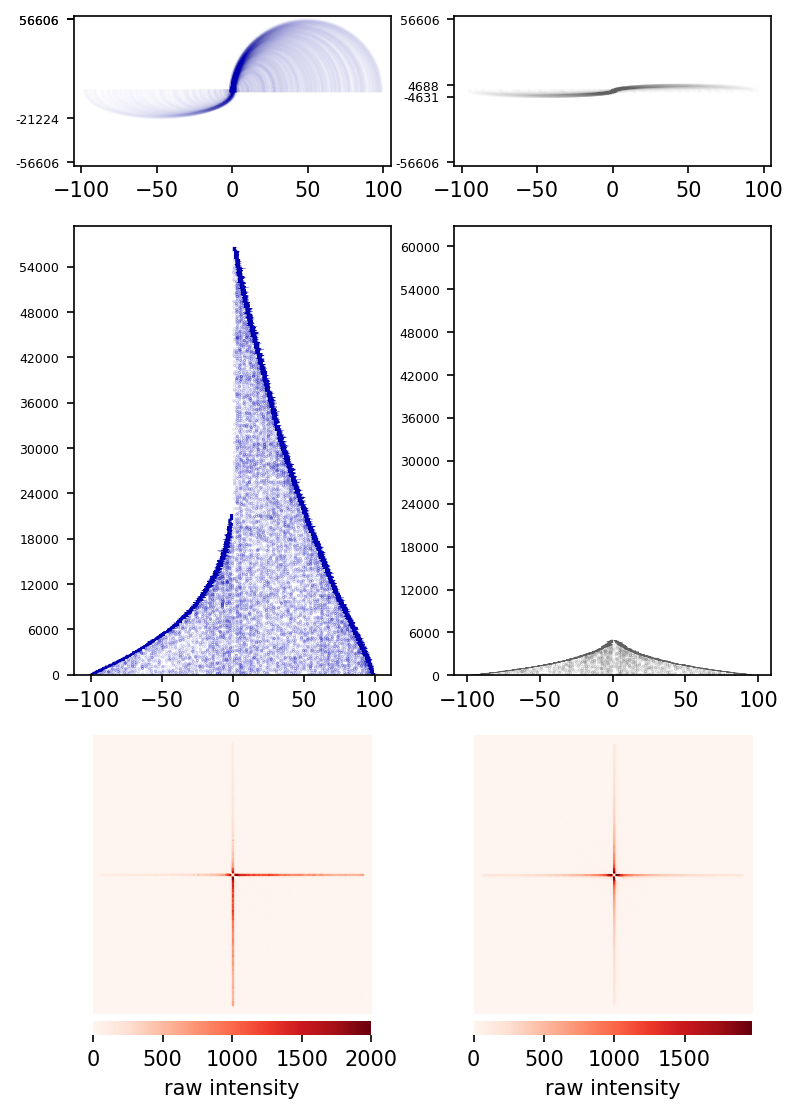

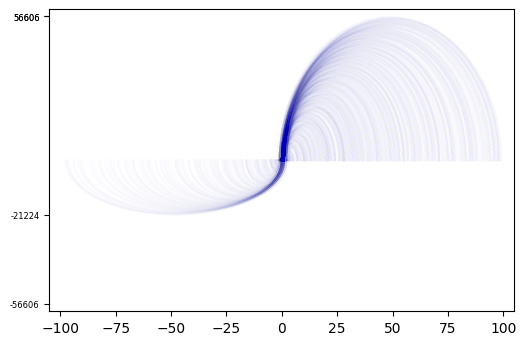

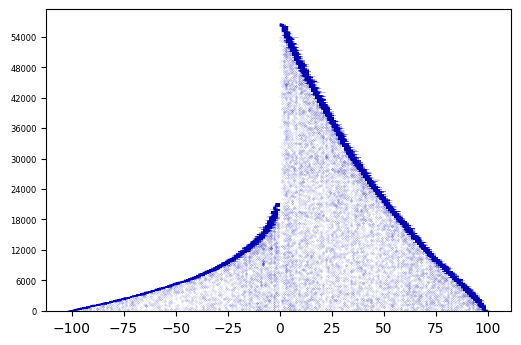

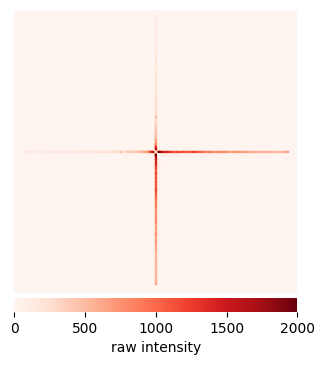

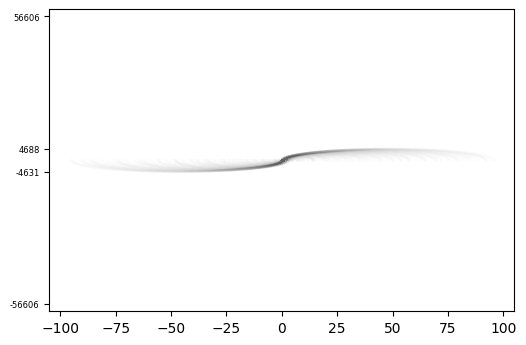

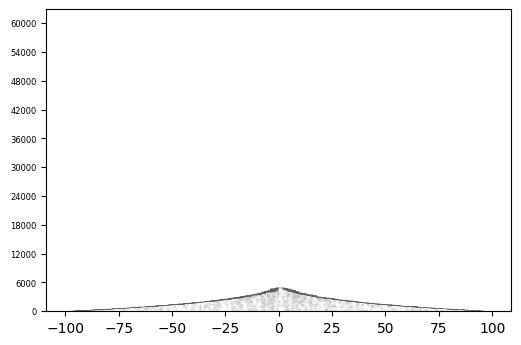

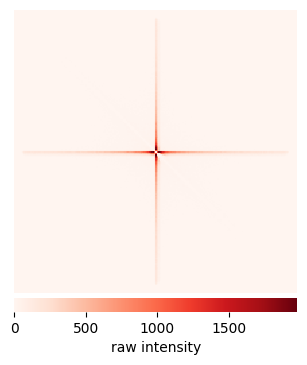

In [98]:
print(expr_name)
print(num_of_total_observed_loops, num_of_total_pseudo_loops)

#### ALL parameters ####

choose_normalized_pseudo_gem_count = True
same_direction = True
observed_loop_sample_gap = 100
pseudo_loop_sample_gap = 1000

observed_loop_sample_gap_ordered_gem_plot = 1
pseudo_loop_sample_gap_ordered_gem_plot = 50

########################

# ------ compute adjcency matrix for heatmap 
in_df_list = [df_combined_gem_mid_left, df_combined_gem_mid_right,
             df_combined_gem_mid_left_pseudo, df_combined_gem_mid_right_pseudo]

in_df_list = [x['100_bin_index_vectors'] for x in in_df_list]
in_position_list = ['Left', 'Right'] * 2
same_direction_list = [False] * len(in_df_list)

parameter_list = list(zip(in_df_list, in_position_list, same_direction_list))

out_list = list([bin_index_vectors_to_matrix(*x) for x in parameter_list])

out_list = [1000 * x / np.max(x) for x in out_list]

adj_mat_mid_left, adj_mat_mid_right, \
adj_mat_mid_left_pseudo, adj_mat_mid_right_pseudo = out_list

tmp_pos_name_list = ['mid_left', 'mid_right', 
                     'mid_left_pseudo', 'mid_right_pseudo']
tmp_adj_mat_list = [adj_mat_mid_left, adj_mat_mid_right,
                   adj_mat_mid_left_pseudo, adj_mat_mid_right_pseudo]

pos_name2adj_mat = {x:y for x, y in zip(tmp_pos_name_list, 
                                        tmp_adj_mat_list)}

#### ------- flipped mid-right adjacnecy matrix and combine with mid-left
pos_name2adj_mat['mid_left_right_combined'] = adj_mat_mid_left + adj_mat_mid_right[::-1, ::-1].T
pos_name2adj_mat['mid_left_right_pseudo_combined'] = adj_mat_mid_left_pseudo + adj_mat_mid_right_pseudo[::-1, ::-1].T

# ------------------------------------------


# idx_list = [pos_name2id[x] for x in pos_name2id.keys() if 'pseudo' in x]
idx_list = [pos_name2id[x] for x in pos_name2id.keys() if 'combine' in x]
# idx_list = range(4)
fig, ax = plt.subplots(3, len(idx_list), 
                       gridspec_kw={'height_ratios': [1, 3, 2]},
#                        sharex = True,
#                        sharey = True,
                       figsize = (3 * len(idx_list), 9),
                      dpi = 150)


for ax_idx, idx in enumerate(idx_list):
    cur_pos_name = id2pos_name[idx]
    pseudo = ('pseudo' in cur_pos_name)

    cur_position = cur_pos_name.split('_')[1].capitalize()
    cur_df = pos_name2df[cur_pos_name]
    print(cur_pos_name)


    template_gem_count_list_left = ['mid_gem_count', 'left_gem_count']
    template_gem_count_list_right = ['mid_gem_count', 'right_gem_count']
    max_gem_count = max(max(pos_name2gem_count['mid_left'][x] for x in template_gem_count_list_left), 
                        max(pos_name2gem_count['mid_right'][x] for x in template_gem_count_list_right), 
                        max(pos_name2gem_count['mid_left_right_combined'][x] for x in template_gem_count_list_left))
#     max_gem_count = max(max(pos_name2gem_count['mid_left'].values()), 
#                         max(pos_name2gem_count['mid_right'].values()), 
#                        max(pos_name2gem_count['mid_left_right_combined'].values()))
    
    if choose_normalized_pseudo_gem_count:
        pseudo_left_mid_gem_count_list = [pos_name2gem_count['mid_left_pseudo'][x] for x in ['normalized_left_gem_count', 
                                                                                             'normalized_mid_gem_count']]
        pseudo_right_mid_gem_count_list = [pos_name2gem_count['mid_right_pseudo'][x] for x in ['normalized_right_gem_count', 
                                                                                               'normalized_mid_gem_count']]
        pseudo_left_mid_right_combined_gem_count_list = [pos_name2gem_count['mid_left_right_pseudo_combined'][x] for x in\
                                                        ['normalized_left_gem_count', 
                                                         'normalized_mid_gem_count']]
    else:
        pseudo_left_mid_gem_count_list = [pos_name2gem_count['mid_left_pseudo'][x] for x in ['left_gem_count',
                                                                                            'mid_gem_count']]
        pseudo_right_mid_gem_count_list = [pos_name2gem_count['mid_right_pseudo'][x] for x in ['right_gem_count',
                                                                                              'mid_gem_count']]
        pseudo_left_mid_right_combined_gem_count_list = [pos_name2gem_count['mid_left_right_pseudo_combined'][x] for x in\
                                                        ['left_gem_count', 
                                                         'mid_gem_count']]
    
    max_gem_count = max(max_gem_count, 
                       max(pseudo_left_mid_gem_count_list),
                       max(pseudo_right_mid_gem_count_list), 
                       max(pseudo_left_mid_right_combined_gem_count_list))
                                           
    if pseudo == 0:
        
        if 'combine' in cur_pos_name:
            left_mid_gem_count = [pos_name2gem_count['mid_left_right_combined']['left_gem_count'],
                                 pos_name2gem_count['mid_left_right_combined']['mid_gem_count']]
            mid_right_gem_count = left_mid_gem_count[::-1]
        else:
            left_mid_gem_count = [pos_name2gem_count['mid_left']['left_gem_count'],
                                  pos_name2gem_count['mid_left']['mid_gem_count']]

            mid_right_gem_count = [pos_name2gem_count['mid_right']['mid_gem_count'],
                                  pos_name2gem_count['mid_right']['right_gem_count']]
        arc_plot_sample = observed_loop_sample_gap
        ordered_gem_plot_sample = observed_loop_sample_gap_ordered_gem_plot
        
    elif pseudo == 1:
        if 'combine' in cur_pos_name:
            left_mid_gem_count = pseudo_left_mid_right_combined_gem_count_list
            mid_right_gem_count = left_mid_gem_count[::-1]
        else:
            left_mid_gem_count = pseudo_left_mid_gem_count_list
        
            mid_right_gem_count = pseudo_right_mid_gem_count_list[::-1]
        
        arc_plot_sample = pseudo_loop_sample_gap
        ordered_gem_plot_sample = pseudo_loop_sample_gap_ordered_gem_plot
        

    print(max_gem_count, left_mid_gem_count, mid_right_gem_count)
    
    if pseudo:
        color = '#606060'
    elif 'CTCF' in expr_name:
        color = '#0000B2'
    elif 'cohesin' in expr_name:
        color = '#005900'
    # ====    
    cur_ax = ax[0][ax_idx]
    
    plot_mid_and_side(cur_ax, cur_df, 
                     left_mid_gem_count,
                     mid_right_gem_count,
                     max_gem_count,
                     cur_position,
                     same_direction = same_direction,                   
                     sample = arc_plot_sample,
                     color = color)
    # ----
    tmp_fig, tmp_ax = plt.subplots(1)
    plot_mid_and_side(tmp_ax, cur_df, 
                     left_mid_gem_count,
                     mid_right_gem_count,
                     max_gem_count,
                     cur_position,
                     same_direction = same_direction,                   
                     sample = arc_plot_sample,
                     color = color)
    tmp_fig.savefig(f'{expr_name}_{cur_pos_name}_arc_plot.png', 
                   dpi = 250)
    
    # ==== 
    cur_ax = ax[1][ax_idx]
    plot_order_gems(cur_ax, cur_df, 
                    max_gem_count, 
                    sample_gap = ordered_gem_plot_sample,
                    pseudo = pseudo,
                    num_of_total_pseudo_loops = num_of_total_pseudo_loops,
                    num_of_total_observed_loops = num_of_total_observed_loops, 
                    same_direction = same_direction,
                    position = cur_position, 
                   color = color, lw = 0.1)
    #----
    tmp_fig, tmp_ax = plt.subplots(1)
    plot_order_gems(tmp_ax, cur_df, 
                    max_gem_count, 
                    sample_gap = ordered_gem_plot_sample,
                    pseudo = pseudo,
                    num_of_total_pseudo_loops = num_of_total_pseudo_loops,
                    num_of_total_observed_loops = num_of_total_observed_loops, 
                    same_direction = same_direction,
                    position = cur_position, 
                   color = color, lw = 0.1)
    tmp_fig.savefig(f'{expr_name}_{cur_pos_name}_ordered_gem_plot.png', 
                   dpi = 250)
    # ====
    cur_ax = ax[2][ax_idx]
    
    adj_mat = pos_name2adj_mat[cur_pos_name]
    
    heatmap_of_matrix(adj_mat, cur_ax, fig, None,  'raw intensity')
    # ----
    tmp_fig, tmp_ax = plt.subplots(1)
    heatmap_of_matrix(adj_mat, tmp_ax, tmp_fig, None,  'raw intensity')
    tmp_fig.savefig(f'{expr_name}_{cur_pos_name}_heatmap_plot.png', 
                   dpi = 250)
    
# plt.tight_layout()   
# plt.show()
# plt.close()


In [70]:
fig.savefig(f'{expr_name}_combine_arc_ordered_gem_heatmap_colorcoded.png', dpi = 200)

# Save each subplots

In [87]:
cur_ax = ax[1][1]
extent = cur_ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.tight_layout()
fig.savefig('ax2_figure.png', bbox_inches=extent.expanded(1.38, 1.2))

<Figure size 600x400 with 0 Axes>